# Semanticist: GloVe CNN
Pretrained GloVe 100d embeddings fed into a 1D CNN for binary classification. 3 conv filter sizes (3,4,5), 100 filters each, dropout 0.5.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as api
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
sns.set_style('whitegrid')

Using device: cuda


## GloVe embeddings
Load pretrained vectors, build vocab from training text.

In [2]:
glove = api.load('glove-wiki-gigaword-300')
print(f'Loaded GloVe: {len(glove)} words, dim={glove.vector_size}')

Loaded GloVe: 400000 words, dim=300


In [3]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

print(f'Loaded {len(df)} rows')

Loaded 1508 rows


## Tokenization and embedding matrix

In [4]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

def get_avg_embedding(text, model, dim=300):
    tokens = tokenize(text)
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

test_emb = get_avg_embedding(df.iloc[0]['text'], glove)
print(f'Embedding shape: {test_emb.shape}')

Embedding shape: (300,)


In [5]:
embeddings = []
for text in tqdm(df['text']):
    emb = get_avg_embedding(text, glove)
    embeddings.append(emb)

embeddings = np.array(embeddings)
print(f'Embeddings: {embeddings.shape}')

100%|██████████| 1508/1508 [00:00<00:00, 2068.19it/s]

Embeddings: (1508, 300)


## Train/val/test split

In [6]:
df['embedding'] = list(embeddings)

df['strat_key'] = df['class'].astype(str) + '_' + df['author'].astype(str)

train_val, test = train_test_split(df, test_size=0.15, stratify=df['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

print(f'Train: {len(train)}, Val: {len(val)}, Test: {len(test)}')

train[['id', 'class', 'topic', 'author']].to_parquet('train.parquet', index=False)
val[['id', 'class', 'topic', 'author']].to_parquet('validate.parquet', index=False)
test[['id', 'class', 'topic', 'author']].to_parquet('test.parquet', index=False)

Train: 1054, Val: 227, Test: 227


In [7]:
X_train = np.stack(train['embedding'].values)
y_train = (train['class'] > 1).astype(int).values

X_val = np.stack(val['embedding'].values)
y_val = (val['class'] > 1).astype(int).values

X_test = np.stack(test['embedding'].values)
y_test = (test['class'] > 1).astype(int).values

X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)

X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.FloatTensor(y_val).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f'X_train: {X_train_t.shape}, y_train: {y_train_t.shape}')

X_train: torch.Size([1054, 300]), y_train: torch.Size([1054])


## Model
3-kernel CNN with max pooling, concat, FC head.

In [8]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim=300, hidden_dims=[512, 256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            layers.append(nn.BatchNorm1d(h_dim))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).squeeze()

model = FeedforwardNN(input_dim=300, hidden_dims=[512, 256, 128, 64]).to(device)
model.load_state_dict(torch.load('semanticist_model.pt', map_location=device))
print(model)
print('Loaded trained model from semanticist_model.pt')

FeedforwardNN(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=64, out_features=1, bias=True)
    (17): Sigmoid()
  )
)
Loaded trained model from semanticist_model.

## Training
10 epochs, Adam lr=1e-3, batch 32.

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
best_val_auc = 0
best_model_state = None
history = {'train_loss': [], 'val_auc': []}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        y_val_prob = model(X_val_t).cpu().numpy()
        val_auc = roc_auc_score(y_val, y_val_prob)
    
    history['train_loss'].append(total_loss / len(train_loader))
    history['val_auc'].append(val_auc)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Val AUC: {val_auc:.4f}')

print(f'Best val AUC: {best_val_auc:.4f}')

model.load_state_dict(best_model_state)

Epoch 10/50 | Loss: 0.0799 | Val AUC: 0.9955
Epoch 20/50 | Loss: 0.1164 | Val AUC: 0.9963
Epoch 30/50 | Loss: 0.0878 | Val AUC: 0.9957
Epoch 40/50 | Loss: 0.1418 | Val AUC: 0.9982
Epoch 50/50 | Loss: 0.1134 | Val AUC: 0.9979
Best val AUC: 0.9987


<All keys matched successfully>

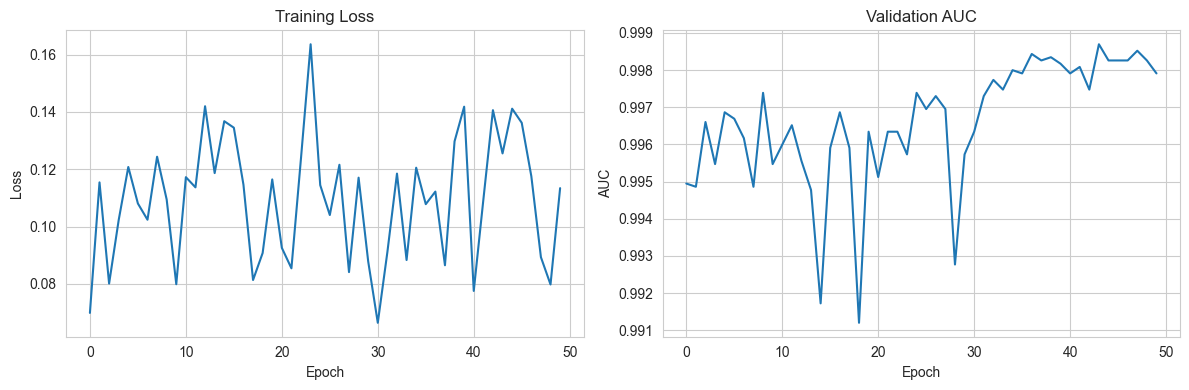

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(history['val_auc'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC')

plt.tight_layout()
plt.show()

## Validation metrics

Validation ROC AUC: 0.9979


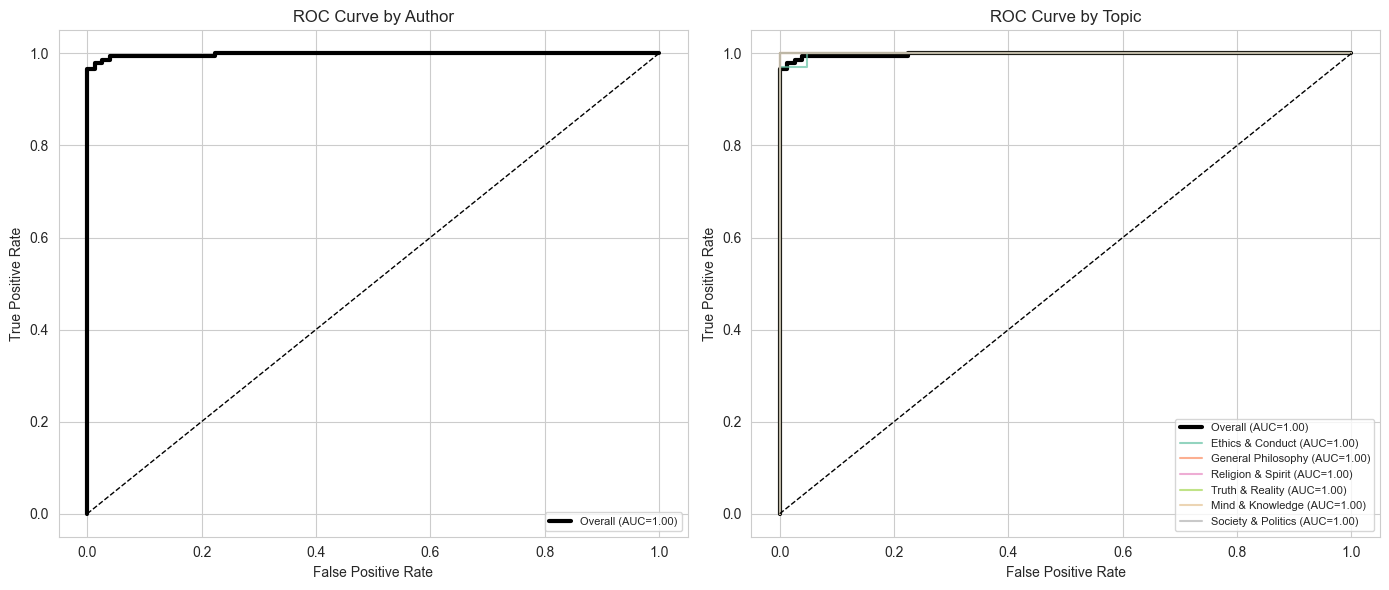

In [11]:
model.eval()
with torch.no_grad():
    y_val_prob = model(X_val_t).cpu().numpy()

val_results = val.copy()
val_results['prob_ai'] = y_val_prob
val_results['actual_binary'] = y_val

auc = roc_auc_score(y_val, y_val_prob)
print(f'Validation ROC AUC: {auc:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
ax1.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')

colors = plt.cm.tab10(np.linspace(0, 1, len(val_results['author'].unique())))
for i, author in enumerate(val_results['author'].unique()):
    mask = val_results['author'] == author
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax1.plot(fpr_sub, tpr_sub, color=colors[i], lw=1.5, alpha=0.7,
                     label=f'{author} (AUC={auc_sub:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve by Author')
ax1.legend(loc='lower right', fontsize=8)

ax2 = axes[1]
ax2.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')

colors_t = plt.cm.Set2(np.linspace(0, 1, len(val_results['topic'].unique())))
for i, topic in enumerate(val_results['topic'].unique()):
    mask = val_results['topic'] == topic
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax2.plot(fpr_sub, tpr_sub, color=colors_t[i], lw=1.5, alpha=0.7,
                     label=f'{topic} (AUC={auc_sub:.2f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve by Topic')
ax2.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Test set

In [12]:
X_test_t = torch.FloatTensor(X_test).to(device)
model.eval()
with torch.no_grad():
    y_test_prob = model(X_test_t).cpu().numpy()
test_auc = roc_auc_score(y_test, y_test_prob)
y_test_pred = (y_test_prob > 0.5).astype(int)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test ROC AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test ROC AUC: 0.9984
Test Accuracy: 0.9824 (98.24%)
